# Simulation

This example is configured to be run on a desktop-computer/laptop for a Trotter-Suzuki expansion of a single step, but more general cases (setting 'consider_custom_pm' / 'consider_perpol' to True or significantly increasing 'number_of_expansion_steps') will require singificant parallelization.

In [1]:
import sys
import os

import numpy as np
import time
import datetime
from scipy.linalg import expm
from matplotlib import pyplot as plt
from tqdm import tqdm
from numpy import random

from QNPI_InRealisticWaveguides import *

c = 299792458 # vacuum speed-of-light (SI units)

## Simulation settings

Set up the simulation by defining which process is to be considered, and what effects are to be included.
This example is configured for running either a asymmetrically group-velocity matched parametric down-conversion or a maximally efficient sum-frequency conversion process (switch by adapting 'consider_PDC' and 'photon_number')

In [3]:
## Simulation settings

# Select if PDC or QFC is considered
consider_PDC = True # if false, a QFC process is considered

# Select if/how nonlinear domain engineering is considered (if both are false, a unpoled/bare crystal is considered)
consider_custom_pm = False # calculates custom poling strucutre using the custom_poling library by Branczyk (https://github.com/abranczyk/custom-poling)
consider_perpol = False # for periodic poling
number_of_expansion_steps = 1 # number of partitions in the Trotter-Suzuki expansion in the nonlinear region (only applied if 'consider_custom_pm' and 'consider_perpol' are set to False)

# Select if losses are to be included
consider_losses = False # considers uniform (linear, frequency independent) losses via virtual beamsplitter like interaction & varying the photon number of the pump
waveguide_loss = (500) / 4.3 # (in 1/m) 1dB/m = 4.3*alpha | alpha being the (classical) loss coefficient as exp(-'waveguide_loss' * 'propagation distance') (in 1/m)

# Select if/how errors in the domain width are included (only works if either consider_custom_pm or consider_perpol are set to True)
consider_domain_wall_errors = False
domain_wall_error_uniform = 0.2 # (maximum) displacement of the domain border, relative to its total width (positive value -> broadening) (i.e. new_position = old position +- domain width*domain_wall_error)
domain_wall_error_random = 0.1 # (maximum) displacement of the domain border, relative to its total width (i.e. new_position = old position +- domain width*domain_wall_error)

# Select if/how error of the domain writing are included (i.e. if the material correctly inverted) (only works if either consider_custom_pm or consider_broadband_pm are set to True)
consider_domain_writing_errors = False
domain_writing_error_rate = 0.05 # percentage of domains that are not written

# Select if fabrication error induced effects of the waveguide inhomogeneity is considered (needs >1 expansion steps)
consider_waveguide_inhomogeneity = False
propagation_constant_max_deviation = 51446.13224147498 # delta beta from simulation (see Weiss et al. 'Quantum nonlinear parametric interaction in realistic waveguides') (in 1/m)

#####################################
## Model parameters

# the vacuum wavelengths and modes to-be-considered
if consider_PDC: # for considering a PDC process (all wavelengths in m)
    
    # sample-case for asymmetric GVM
    wl_s = 1550e-9
    wl_p = 735e-9
    wl_i = (1/wl_p - 1/wl_s)**(-1)

    mode_pump = "TM00"
    mode_signal = "TE00"
    mode_idler = "TE20"
    
else: # for considering a QFC process (all wavelengths in m)
    
    # sample-case for a SFG process with assymetric GVM in the U_si transfer function (formally exchanging the signal and idler gives the corresponding DFG process)
    wl_s = 1550e-9 # in m (for QFC)
    wl_p = 1570e-9 # in m (for PDC) 
    wl_i = (1/wl_p + 1/wl_s)**(-1) # in m (for QFC) 

    mode_pump = "TM00"
    mode_signal = "TM00"
    mode_idler = "TM00"

# set up the waveguide data
start = 0e-3 # start of the linear waveguide, in m
start_nl = 0e-3 # start of the nonlinear interaction, in m
end_nl = 5e-3 # end of the nonlinear interaction, in m (is approximated when domain-engineered phase-matching is considered)
end = 5e-3 # end of the linear waveguide, in m

# set up the pump pulse
initial_phase = 0*np.pi/4 # initial (global) phase of the pump-pulse
photon_number = 5e6 # number of photons in one pump-pulse (reference values: 5e6 for PDC with asymmetric GVM, 5e3 for maximally efficient TM-TM-TM PDC/QFC)
bandwidth =  4*2*np.pi * 0.441e12 # bandwidth of pump-pulse in (angular) frequency
z0 = start # location of the pump-pulse at t=t0

# the shape of the pump amplitude | here a gaussian is considered
amplitude_pump_raw = lambda z,photon_num,v_p_c,z0,bandwidth : np.sqrt(photon_num)/np.power(np.pi*((v_p_c/bandwidth)**2),1/4) * np.exp(-0.5*((z-z0)**2) / ((v_p_c/bandwidth)**2))

# set up the numerics of the simulator
plotting_range = 20*bandwidth # frequency range, around the center frequency, in which the interaction is modelled (in 2*pi/s)
number_of_freq_points = 501

In [5]:
## calculate the material refractive indices from the Sellmeier equations
SellmeierEqs = Sellmeier()

# Lithium Niobate
n_p = SellmeierEqs.Sellmeier_LN(wl_p, extraordinary_axis=False)
n_s = SellmeierEqs.Sellmeier_LN(wl_s, extraordinary_axis=False)
n_i = SellmeierEqs.Sellmeier_LN(wl_i, extraordinary_axis=False)

n_p_eo = SellmeierEqs.Sellmeier_LN(wl_p, extraordinary_axis=True)
n_s_eo = SellmeierEqs.Sellmeier_LN(wl_s, extraordinary_axis=True)
n_i_eo = SellmeierEqs.Sellmeier_LN(wl_i, extraordinary_axis=True)

# SiO2
n_Si02_p = SellmeierEqs.Sellmeier_SiO2(wl_p)
n_Si02_s = SellmeierEqs.Sellmeier_SiO2(wl_s)
n_Si02_i = SellmeierEqs.Sellmeier_SiO2(wl_i)

# definition in a coordinate system where the optical axis is aligned with the y-direction and propagation occurs along the z-direction
n_pump = [n_p, n_p_eo, n_p]
n_signal = [n_s, n_s_eo, n_s]
n_idler = [n_i, n_i_eo, n_i]

## Solving

Read the dispersion data calculated from a mode solver, correct it for the errors that are usually included, and calculate the group-velocity dispersion

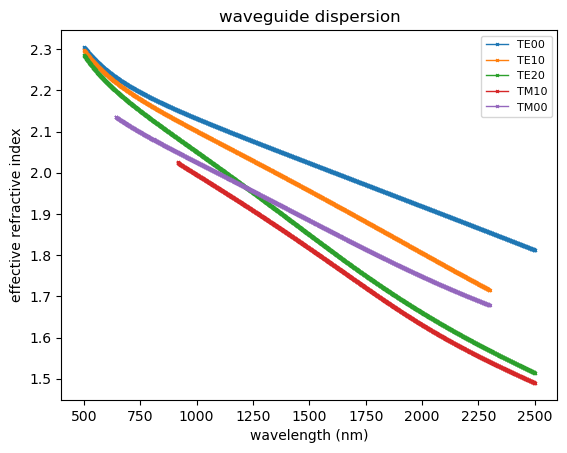

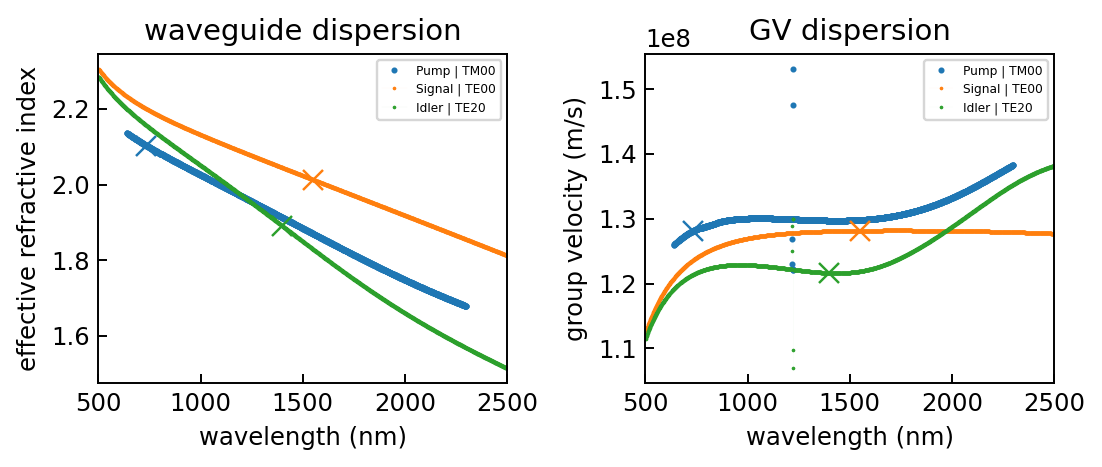

-------------------------------------------
PUMP | TM00 mode at 735.0 nm:
2.1028 | effective refractive index
128150552.4033 m/s | group velocity
-------------------------------------------
-------------------------------------------
SIGNAL | TE00 mode at 1550.0 nm:
2.0131 | effective refractive index
128161775.6307 m/s | group velocity
-------------------------------------------
-------------------------------------------
IDLER | TE20 mode at 1397.852760736196 nm:
1.8913 | effective refractive index
121643923.611 m/s | group velocity
-------------------------------------------
-------------------------------------------
0.0938 deg | phase-matching angel due to GVM


In [7]:
# calculate the dispersion data

# info about the mode solver file
n_effs_file = '../ModeSolverData/500nm-2500nm_2umTopWidth.txt'
mode_order = np.array(["TM00","TM10","TE20","TE10","TE00"]) # mode order at the highest wavelength (ascending, i.e. starting with the lowest order)
dispersion_wls = 1e-9*np.arange(500,2500+1,1) # wavelengths at which the effective refractive index was calculated by the mode solver (in m)

# set up the dispersion class
WaveguideDispersion = Dispersion(n_effs_file, mode_order, dispersion_wls, make_plots=False)

## manually correct the anti-crossings inherent in the mode solver data (turn them into actual crossings)
# crossing 1
swap_index1 = 808e-9 # location of the anticrossing (as a wavelengths, in m) 
lower_mode1 = 'TM00' # lower order mode which anticrosses (in terms of the array 'mode_order')
higher_mode1 = 'TM10' # higher order mode which anticrosses (in terms of the array 'mode_order')
# crossing 2
swap_index2 = 1225e-9 # 725 # location (as a wavelengths, in m) 
lower_mode2 = 'TM00' # lower order mode which anticrosses (in terms of the array 'mode_order')
higher_mode2 = 'TE20' # higher order mode which anticrosses (in terms of the array 'mode_order')

anticrossing_correction_info = [[swap_index1,lower_mode1,higher_mode1],[swap_index2,lower_mode2,higher_mode2]]
WaveguideDispersion.correct_anticrossings(anticrossing_correction_info, make_plots=False)

## manually set (plotting) ranges in which the refractive indices are well confined and un-hybridized (this may need to be determined from the mode solver) 
start_stop_indices = [[140, 415, 0, 0, 0],[1800, len(dispersion_wls), len(dispersion_wls), 1800, len(dispersion_wls)]] # start and stop indices in terms of the wavelength array 'dispersion_wls' and corresponding to the modes in 'mode_order'
WaveguideDispersion.plot_eff_ref_index(start_stop_indices)

## calculate the group velocities
wls = [wl_p, wl_s, wl_i] # wavelengths between which interaction is to be considered
modes = [mode_pump, mode_signal, mode_idler] # waveguide modes between which interaction is to be considered
WaveguideDispersion.calc_group_velocities(wls, modes, make_plots=False)

## correct for the contribution of the anticrossing correction in the group-velocity data
WaveguideDispersion.correct_anticrossings_gv(['TM00',775e-9,840e-9], make_plots=True) # arguments give where the anticrossing correction was applied, and in which wavelength range a correction is to be applied

#WaveguideDispersion.plot_dispersion_data(wls, modes)

Read the electric displacement field data across the waveguide cross-section, calculated from a mode solver, and calculate the nonlinear interaction coefficients

reading pump field modal data...


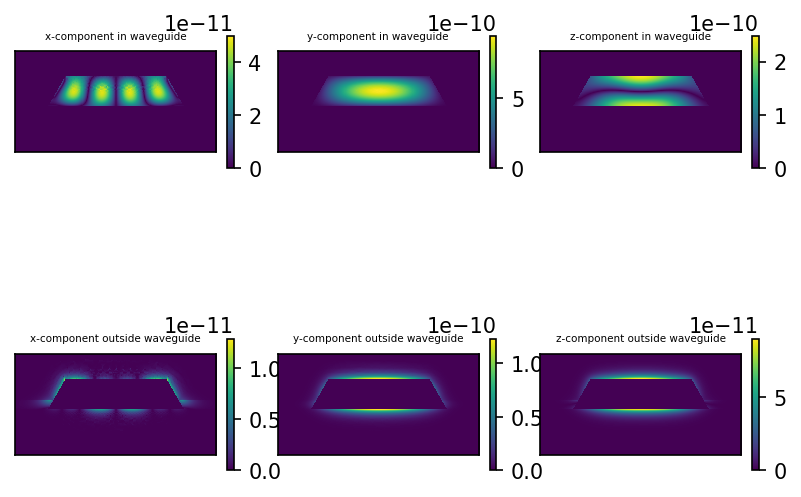

reading signal field modal data...


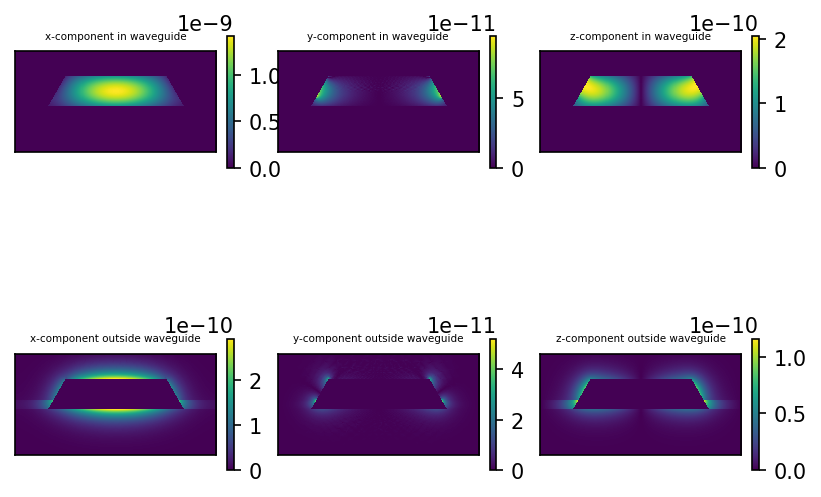

reading idler field modal data...


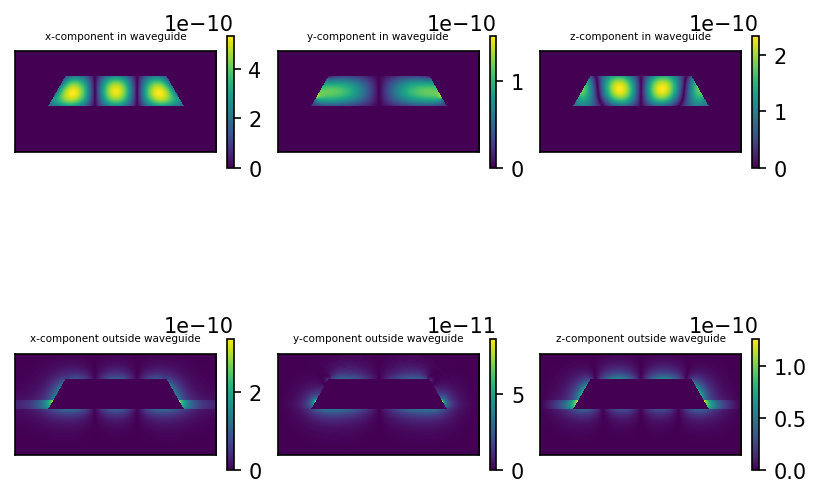

finished reading modal data
------------------------------------------------------
Nonlinear overlap integrals PDC:
[3.02859389e-14] d33 contribution
[2.98356327e-12] d31 contribution
[3.23731879e-13] d22 contribution
[8.32152852e-15] dxzx contribution (d31)
[7.00408364e-15] dxxz contribution (d31)
[9.08178869e-17] dyyz contribution (d31)
[6.89496416e-16] dyzy contribution (d31)
[3.29446502e-12] dzxx contribution (d31)
[3.4271221e-13] dzyy contribution (d31)
[2.89764302e-15] dyyy contribution (d22)
[-1.26730672e-13] dyxx contribution (d22)
[-1.286322e-13] dxxy contribution (d22)
[-6.54713638e-14] dxyx contribution (d22)
[-3.02859389e-14] dzzz contribution (d33)
------------------------------------------------------
------Calculated nonlinear coupling coefficients------
--------------as defined in Weiss et al.--------------
------------------------------------------------------
202.60162215931487 | PDC nonlinear coupling coefficient
0.15934118460972696 | SPM nonlinear coupling coefficie

In [9]:
# calculate the nonlinear interaction coefficients

# electric displacement field data of the interacting modes from COMSOL simulation (at central frequencies)
if consider_PDC:
    # store the electric displacement field data of the pump, signal and idler optical modes
    input_field_files = [['../ModeSolverData/'+str(int(1e9*wl_p))+'nm/'+mode_pump+'_ZCut_XData.txt', '../ModeSolverData/'+str(int(1e9*wl_p))+'nm/'+mode_pump+'_ZCut_YData.txt', '../ModeSolverData/'+str(int(1e9*wl_p))+'nm/'+mode_pump+'_ZCut_ZData.txt'], \
                         ['../ModeSolverData/'+str(int(1e9*wl_s))+'nm/'+mode_signal+'_ZCut_XData.txt', '../ModeSolverData/'+str(int(1e9*wl_s))+'nm/'+mode_signal+'_ZCut_YData.txt', '../ModeSolverData/'+str(int(1e9*wl_s))+'nm/'+mode_signal+'_ZCut_ZData.txt'], \
                         ['../ModeSolverData/'+str(int(1e9*wl_i))+'nm/'+mode_idler+'_ZCut_XData.txt', '../ModeSolverData/'+str(int(1e9*wl_i))+'nm/'+mode_idler+'_ZCut_YData.txt', '../ModeSolverData/'+str(int(1e9*wl_i))+'nm/'+mode_idler+'_ZCut_ZData.txt']]
else:
    # store the electric displacement field data of the pump, signal and idler optical modes
    input_field_files = [['../ModeSolverData/'+str(int(1e9*wl_p))+'nm/'+mode_pump+'_ZCut_XData.txt', '../ModeSolverData/'+str(int(1e9*wl_p))+'nm/'+mode_pump+'_ZCut_YData.txt', '../ModeSolverData/'+str(int(1e9*wl_p))+'nm/'+mode_pump+'_ZCut_ZData.txt'], \
                         ['../ModeSolverData/'+str(int(1e9*wl_s))+'nm/'+mode_signal+'_ZCut_XData.txt', '../ModeSolverData/'+str(int(1e9*wl_s))+'nm/'+mode_signal+'_ZCut_YData.txt', '../ModeSolverData/'+str(int(1e9*wl_s))+'nm/'+mode_signal+'_ZCut_ZData.txt'],\
                         ['../ModeSolverData/'+str(int(np.round(1e9*wl_i,0)))+'nm/'+mode_idler+'_ZCut_XData.txt', '../ModeSolverData/'+str(int(np.round(1e9*wl_i)))+'nm/'+mode_idler+'_ZCut_YData.txt', '../ModeSolverData/'+str(int(np.round(1e9*wl_i)))+'nm/'+mode_idler+'_ZCut_ZData.txt']]

waveguide_data = [2e-6, 0.6e-6, 0.42e-6, 60] # waveguide top width (in m), thickness of the LN thin film (in m), waveguide etch depth (in m), waveguide sidewall angle (in deg)
sampling = [np.arange(-2e-6,2e-6+0.01e-6,0.01e-6), np.arange(-1e-6,1e-6+0.01e-6,0.01e-6)] # in m | the [x,y] coordinates of the data points in the COMSOL files

# Simulation data predifined under 'Simulation settings' and calculated from the waveguide dispersion | (to be feed into the NonlinearOverlap class)
wls = [wl_p, wl_s, wl_i]
input_ref_index_data = [WaveguideDispersion.neff_p, n_pump, n_Si02_p, WaveguideDispersion.neff_s, n_signal, n_Si02_s, WaveguideDispersion.neff_i, n_idler, n_Si02_i]
input_group_velocities = [WaveguideDispersion.get_vg(2*np.pi*c / wl_p, mode_pump), WaveguideDispersion.get_vg(2*np.pi*c / wl_p, mode_signal), WaveguideDispersion.get_vg(2*np.pi*c / wl_p, mode_idler)]

# calculate nonlinear interaction coefficients
NonlinearWaveguide = NonlinearOverlap(wls, input_field_files, waveguide_data, sampling, input_ref_index_data, input_group_velocities, consider_PDC, make_plots=True)
interaction_coeffts = NonlinearWaveguide.calc_nonlinear_interaction_coeffts()

Calculate the propagator solving the equations of motion

End of the nonlinear region: 5.0 mm


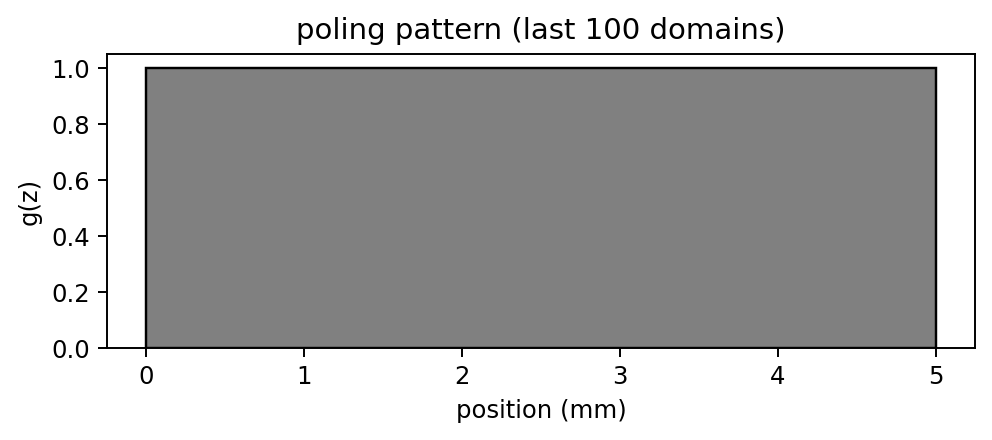

calculating propagator...
-----------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:38<00:00, 79.09s/it]

-----------------------------
finished calculating propagator
total computation time: 0:03:57 s


In [11]:
# calculate the propagator solving the EOM

# Simulation data predifined under 'Simulation settings' and calculated from the waveguide dispersion and the overlap integrals | (to be feed into the Simulator class)
simulation_settings = [consider_PDC, consider_custom_pm, consider_perpol, consider_losses, consider_domain_wall_errors, consider_domain_writing_errors, consider_waveguide_inhomogeneity]
error_data = [waveguide_loss, domain_wall_error_uniform, domain_wall_error_random, domain_writing_error_rate, propagation_constant_max_deviation]
sim_data =  [wl_p, wl_s, wl_i, WaveguideDispersion.get_vg(2*np.pi*c / wl_p, mode_pump), photon_number, bandwidth, initial_phase]
crystal_data = [start_nl,end_nl,start,end]
interaction_coefficients = interaction_coeffts

# the shape of the pump amplitude
amplitude_pump = lambda z,photon_num : amplitude_pump_raw(z,photon_num,WaveguideDispersion.v_p_c,z0,bandwidth)
# sampling of the pump pulse for fourier transforms
pump_amplitude_sampling_step = (WaveguideDispersion.v_p_c/bandwidth)/25 # number of points at which the number density amplitude of the pump is calculated
pump_amplitude_sampling = np.arange(z0-10*WaveguideDispersion.v_p_c/bandwidth,z0+10*WaveguideDispersion.v_p_c/bandwidth,pump_amplitude_sampling_step)

TestSimulator = QNPISimulator(sim_data, crystal_data, number_of_freq_points, plotting_range, amplitude_pump, interaction_coefficients, WaveguideDispersion, number_of_expansion_steps=number_of_expansion_steps, simulation_settings=simulation_settings, error_data=error_data)

# ## exemplary target phase-matching function for when 'consider_custom_pm' is set to True
# # define a target, custom phase-matching funtion (here: set-up a gaussian)
# width_gaussian = 5/np.abs(end_nl-start_nl)
# height_gaussian = 4
# centre_gaussian = 2*np.pi*WaveguideDispersion.neff_p/wl_p - 2*np.pi*WaveguideDispersion.neff_s/wl_s - 2*np.pi*WaveguideDispersion.neff_i/wl_i # intrinsic phase-mismatch (PDC)
# centre_gaussian = -2*np.pi*WaveguideDispersion.neff_p/wl_p - 2*np.pi*WaveguideDispersion.neff_s/wl_s + 2*np.pi*WaveguideDispersion.neff_i/wl_i # intrinsic phase-mismatch (QFC - SFG)
# target_pmf = lambda k : 1j*(height_gaussian/np.sqrt(2*np.pi*(width_gaussian**2))) * np.exp(-((k-centre_gaussian)**2)/(2*(width_gaussian**2))) \
#                         * np.exp(1j * np.abs(end_nl-start_nl)/2 * k) 

target_pmf = []
K = TestSimulator.calculate_propagator(input_target_func=target_pmf)

# ## calculate only the n-th element of the Trotter-Suzuki expansion (for supercomputer parallelization)
# K_0 = TestSimulator.calculate_TSE_element_n(0, input_target_func=target_pmf)

Generate and visualize the outputs

diagonalizing matrices...
finished diagonalizing matrices


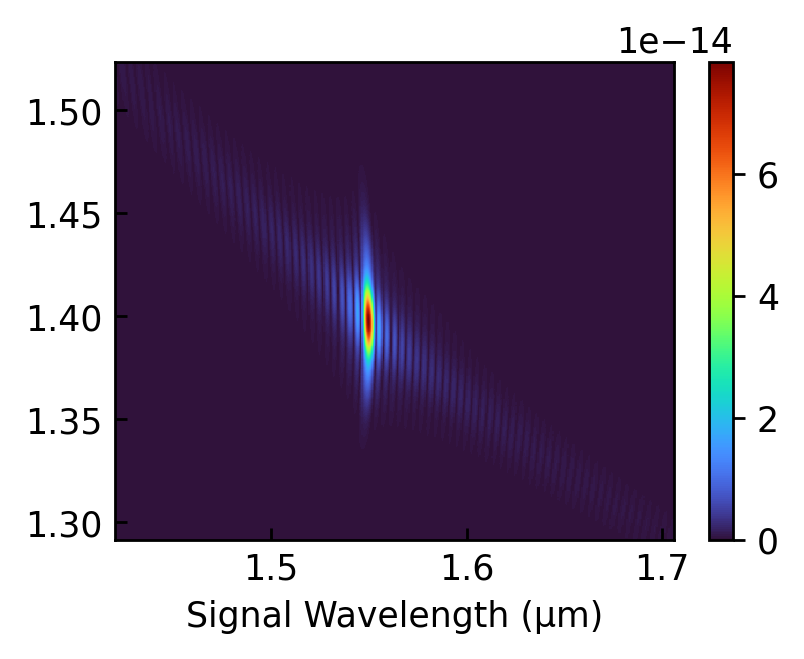

down-converted signal/idler photon number: 0.44174859795635807 / 0.44175053676551485
Schmidt number: 1.0693191815304912


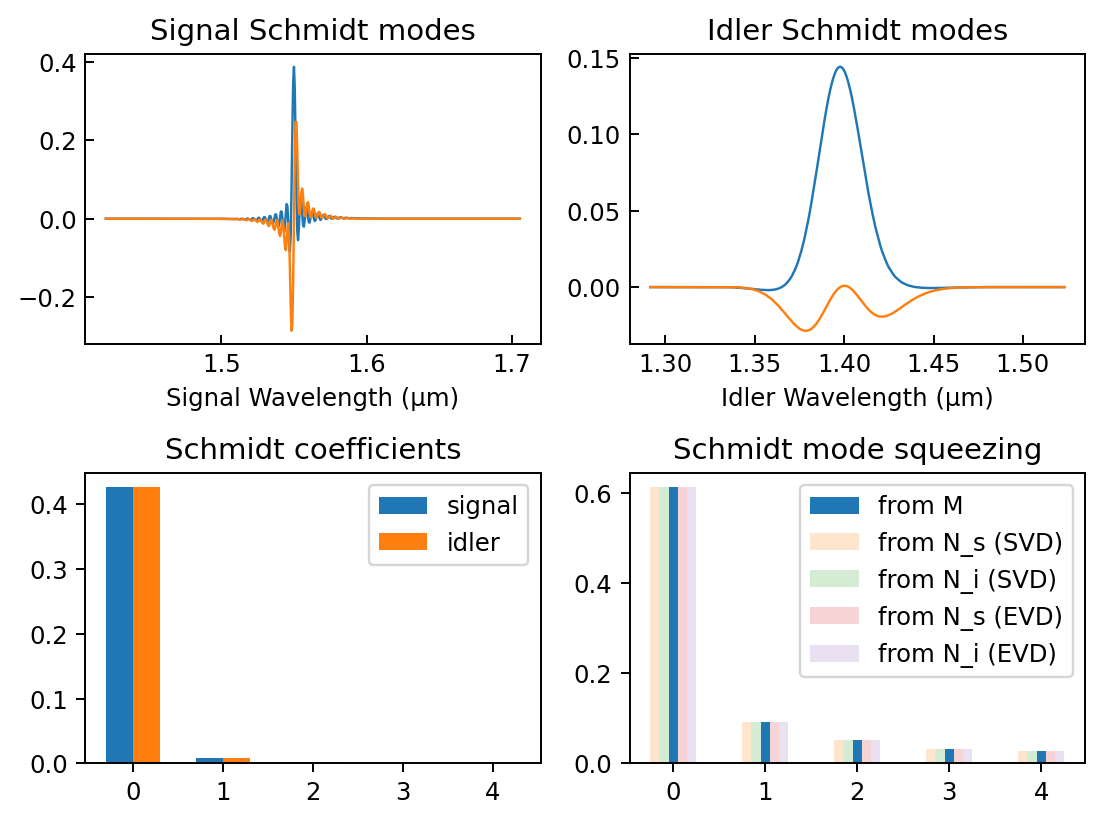

Schmidt number: 1.0693191815304912


In [15]:
# generate the output data from the simulator 

Output = Outputs(TestSimulator)
OutputData = Output.calculate_moments_PDC() # modify to 'calculate_moments_PDC()' or 'calculate_moments_QFC()' as needed